In [1]:
# Author: Pongpisit Thanasutives

import lookahead
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams.update({'font.size': 18})

from tqdm import trange

In [2]:
# Create a simple signal with two frequencies
dt = 0.001
t = torch.tensor(np.arange(0,1,dt)).float().requires_grad_(True); n=len(t)
f = torch.sin(2*torch.pi*50*t) + torch.sin(2*torch.pi*120*t) # Sum of 2 frequencies
f_clean = f.detach()
f = f + 2.5*torch.randn(len(t)) # Add some noise

In [3]:
class FFTNN(nn.Module):
    def __init__(self, c=0.0, minmax=(-5.0, 5.0)):
        super(FFTNN, self).__init__()
        self.c = nn.Parameter(data=torch.FloatTensor([c]))
        self.mini = minmax[0]
        self.maxi = minmax[1]
    def forward(self, PSD):
        th = PSD.mean()+torch.clamp(self.c, min=self.mini, max=self.maxi)*PSD.std()
        indices = F.relu(PSD-th)
        d = torch.ones_like(indices)
        d[indices>0] = indices[indices>0]
        indices = indices / d
        return indices

In [4]:
model = FFTNN()

In [5]:
opt = lookahead.LookaheadAdam(model.parameters(), lr=1)

In [6]:
def closure():
    opt.zero_grad()
    loss = F.mse_loss(torch.fft.ifft(model(PSD)*fft).real, f_clean)
    loss.backward(retain_graph=True)
    return loss

In [7]:
fft = torch.fft.fft(f)
PSD = (1/len(t))*torch.abs(fft)**2
for _ in trange(1000): opt.step(closure)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/pongpisit/Desktop/fun/FFT/lookahead.py:38: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1025.)
  slow.add_(group['lookahead_alpha'], fast_p.data - slow)
100%|██████████| 1000/1000 [00:00<00:00, 1469.28it/s]


In [8]:
out = torch.fft.ifft(model(PSD)*fft).real
F.mse_loss(out, f_clean).item()

0.002357619581744075

In [9]:
model.c

Parameter containing:
tensor([4.6298], requires_grad=True)

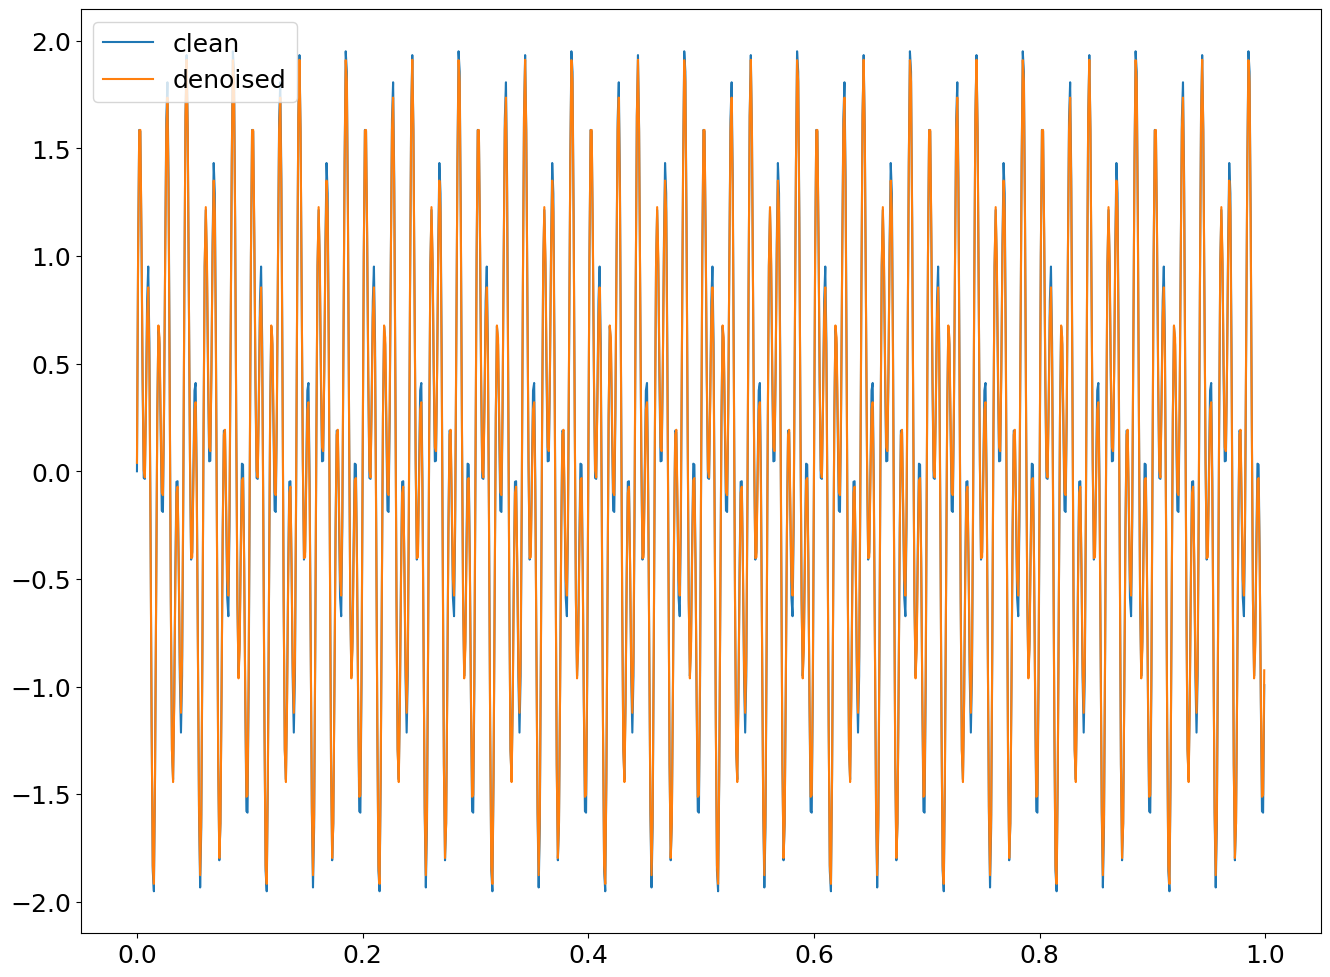

In [10]:
plt.plot(t.detach().numpy(), f_clean.detach().numpy(), label='clean')
plt.plot(t.detach().numpy(), out.detach().numpy(), label='denoised')
plt.legend()
plt.show()